In [86]:
import pytorch_lightning as pl
from torch import nn
import torchmetrics
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import models
from torch import Tensor
from pytorch_lightning import LightningDataModule
import matplotlib.pyplot as plt
import numpy as np

# Our model

Model based is on MobileNet architecture.

![architecture](mobilenet.png "Title")

It was trained on augmented dataset form kaggle [Healthy vs Rotten](https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten/data) 

Augments used on the original dataset were from the [Albumenations](https://albumentations.ai/) python library.  
Augments we used for this project:
```python
          A.Rotate(limit=30, p=0.5),
          A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=0, p=0.5),
          A.HorizontalFlip(p=0.5),
          A.ChannelShuffle(p=0.5),
          A.RandomBrightnessContrast(p=0.5),

In [80]:
class FruitVegMobNet(pl.LightningModule):
    """MobileNetV2 model for the FruitVeg dataset."""

    def __init__(self, lr: float = 0.0001, num_classes: int = 0) -> None:
        """Initialize the FruitVegMobileNet model."""
        super().__init__()

        mobilenetV2Model = models.mobilenet_v2(pretrained=True)

        self.backbone = mobilenetV2Model.features
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(inplace=True)
        self.fc1 = nn.LazyLinear(num_classes)
        self.loss_function = nn.CrossEntropyLoss()
        self.lr = lr

        self.train_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        self.train_macro_f1 = torchmetrics.F1Score(
            num_classes=num_classes, task="multiclass", average="macro"
        )

        self.val_macro_f1 = torchmetrics.F1Score(
            num_classes=num_classes, task="multiclass", average="macro"
        )

        self.train_macro_recall = torchmetrics.Recall(
            num_classes=num_classes, task="multiclass", average="macro"
        )

        self.val_macro_recall = torchmetrics.Recall(
            num_classes=num_classes, task="multiclass", average="macro"
        )

        self.train_macro_precision = torchmetrics.Precision(
            num_classes=num_classes, task="multiclass", average="macro"
        )

        self.val_macro_precision = torchmetrics.Precision(
            num_classes=num_classes, task="multiclass", average="macro"
        )

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass of the model."""
        self.backbone.eval()
        with torch.no_grad():
            x = self.backbone(x)
            x = self.pooling(x).flatten(1)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x

    def training_step(
        self, train_batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> Tensor:
        """Training step of the model."""
        inputs, labels = train_batch
        outputs = self.forward(inputs.float())
        loss = self.loss_function(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        outputs = F.softmax(outputs, dim=1)
        self.train_acc(outputs, labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.train_macro_f1(outputs, labels)
        self.log("train_macro_f1", self.train_macro_f1, on_epoch=True, on_step=False)
        self.train_macro_recall(outputs, labels)
        self.log(
            "train_macro_recall",
            self.train_macro_recall,
            on_epoch=True,
            on_step=False,
        )
        self.train_macro_precision(outputs, labels)
        self.log(
            "train_macro_precision",
            self.train_macro_precision,
            on_epoch=True,
            on_step=False,
        )
        return loss

    def validation_step(
        self, val_batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> Tensor:
        """Validate step of the model."""
        inputs, labels = val_batch
        outputs = self.forward(inputs.float())
        loss = self.loss_function(outputs, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        outputs = F.softmax(outputs, dim=1)
        self.val_acc(outputs, labels)
        self.log("val_acc", self.val_acc, on_epoch=True, on_step=False)
        self.val_macro_f1(outputs, labels)
        self.log("val_macro_f1", self.val_macro_f1, on_epoch=True, on_step=False)
        self.val_macro_recall(outputs, labels)
        self.log(
            "val_macro_recall", self.val_macro_recall, on_epoch=True, on_step=False
        )
        self.val_macro_precision(outputs, labels)
        self.log(
            "val_macro_precision",
            self.val_macro_precision,
            on_epoch=True,
            on_step=False,
        )
        return loss

    def configure_optimizers(self) -> optim.Optimizer:
        """Configure the optimizer of the model."""
        optimizer = optim.Adam(self.parameters(), self.lr)
        return optimizer


FruitVegDatamodule locted in src directory.  
We are spliting a dataset into train, validation and test with 80%, 10%, 10% proportions.   
Generator seed give us reproducible code.

In [81]:
import pytorch_lightning as pl
from torch import Generator
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder


class FruitVegDatamodule(pl.LightningDataModule):
    """DataModule for the FruitVeg dataset."""

    def __init__(self, batch_size: int = 32) -> None:
        """Initialize the FruitVegDatamodule."""
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage: str = None) -> None:
        """Make setup the FruitVeg dataset."""
        transform = transforms.Compose(
            [
                transforms.Resize(200),
                transforms.CenterCrop(200),
                transforms.ToTensor(),
                transforms.Normalize((0), (1)),
            ]
        )

        dataset = ImageFolder(
            root="data/processed/Fruit And Vegetable Diseases Dataset",
            transform=transform,
        )

        seed = Generator().manual_seed(42)
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        self.train_dataset, self.test_dataset, self.val_dataset = random_split(
            dataset, [train_size, test_size, val_size], seed
        )

    def train_dataloader(self) -> DataLoader:
        """Return the DataLoader for the training dataset."""
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8
        )

    def test_dataloader(self) -> DataLoader:
        """Return the DataLoader for the test dataset."""
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8
        )

    def val_dataloader(self) -> DataLoader:
        """Return the DataLoader for the validation dataset."""
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8
        )


Go up the directory tree to so that notebook finds needed module

In [22]:
%cd ..

c:\Users\szymo\PROGRAMMING\temp\ClassificationFruitVegQuality


c:\Users\szymo\PROGRAMMING\temp\ClassificationFruitVegQuality\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [82]:
dm = FruitVegDatamodule(batch_size=32)

In [87]:
def load_data_module(dm: LightningDataModule) -> DataLoader:
    dm.setup()
    return DataLoader(dm.test_dataset, batch_size=20, shuffle=True)

test_loader = load_data_module(dm)

Load model weights form a path

In [88]:
class_names = test_loader.dataset.dataset.classes
num_classes = len(class_names)


model_path = "models/fruit_veg_mobilenet/epoch=24-val_loss=0.33.ckpt"
model = FruitVegMobNet.load_from_checkpoint(model_path, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\szymo\PROGRAMMING\temp\ClassificationFruitVegQuality\.venv\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.2, which is newer than your current Lightning version: v2.3.1
c:\Users\szymo\PROGRAMMING\temp\ClassificationFruitVegQuality\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\szymo\PROGRAMMING\temp\ClassificationFruitVegQuality\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\szymo\PROGRAMM

FruitVegMobNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, e

Model predicition performed on a test dataset

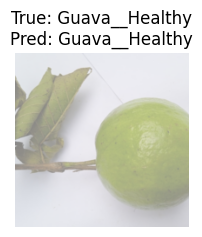

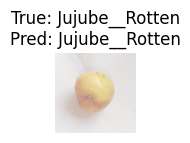

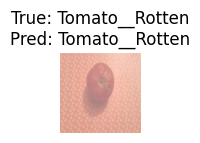

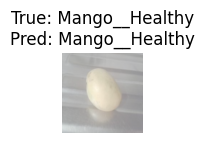

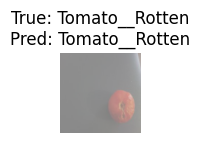

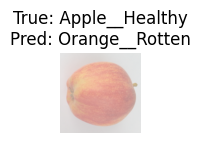

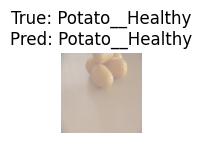

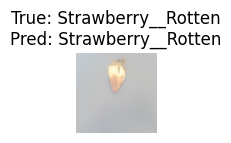

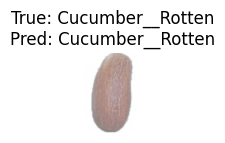

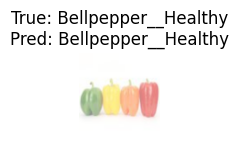

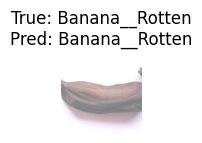

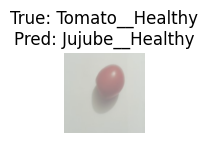

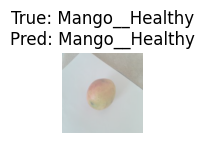

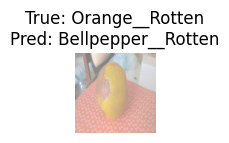

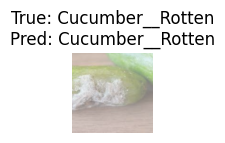

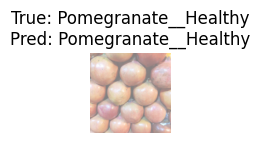

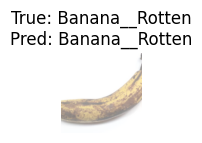

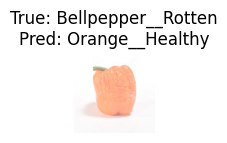

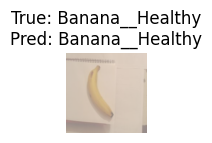

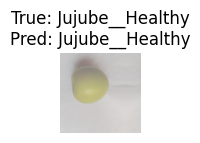

In [89]:
images, labels = next(iter(test_loader))
images = images.to(device)
model.eval()
with torch.no_grad():
    outputs = model(images)
_, predicted = torch.max(outputs, 1)   

plt.figure(figsize=(13, 13))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    img = images[i].cpu() / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    true_label = class_names[labels[i].cpu()]
    predicted_label = class_names[predicted[i].cpu()]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")
    plt.show()

# Model metrics

In [91]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/FruitVegMobNet_logs20240704-094947/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19732), started 0:00:19 ago. (Use '!kill 19732' to kill it.)